In [8]:
# imports and functions

import torch
import numpy as np
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

from models.registration_model import RegistrationModel
import models
import registration # loads the package not the file
import utils

In [17]:
# load the model and dataloader
ckpt_path = "/data/vision/polina/users/layjain/ivus-temporal/checkpoints/registration/3/3-8-3_len30-epochs500-mlp2-lossMSE-lr0.01/saved_models/model_68.pth"

def load_model(ckpt_path):
    checkpoint = torch.load(ckpt_path)
    model = RegistrationModel(checkpoint['args'])
    model_dict = model.state_dict()
    assert set(model_dict.keys()) == set(checkpoint['model'].keys())
    model_dict.update(checkpoint['model'])
    model.load_state_dict(model_dict)
    return model

def get_dataloader(ckpt_path, mode="train"):
    checkpoint = torch.load(ckpt_path)
    args = checkpoint['args']
    args.use_cached_dataset = True # Override
    # begin: copy of get_dataloader from registration.py
    from data.hdf5_clips import UnlabelledClips
    from torch.utils.data import DataLoader
    root = os.path.join(args.data_path, mode)
    save_file = f"/data/vision/polina/users/layjain/pickled_data/pretraining/ivus_{mode}_len_{args.clip_len}.h5"
    dataset = UnlabelledClips(root, frames_per_clip=args.clip_len, transform=None, cached=args.use_cached_dataset, save_img_size=args.img_size, save_file=save_file)
    print(f"Dataset size: {len(dataset)}")
    dataloader = DataLoader(dataset, batch_size=args.batch_size, pin_memory=True, num_workers = args.workers, shuffle=True)
    return args, dataloader
    
model = load_model(ckpt_path)
model.eval()
args, dataloader = get_dataloader(ckpt_path)
print(model)

stride Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
stride Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
stride Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
stride Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
stride Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
stride Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
stride Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
stride Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
stride Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
stride Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Loading cached data from /data/vision/polina/users/layjain/pickled_data/pretraining/ivus_train_len_30.h5
Dataset size: 2228
RegistrationModel(
  (encoder_localize

In [20]:
def get_clip_np(images, model, args, idx=0):
    B, T, H, W, C = images.shape
    assert C==1
    assert H==W
    images = images.transpose(2, 4) # B x T x C x W x H
    images_tr, template = model(images) # B x T x W x H, B x 1 x W x H
    mse_loss = registration.registration_loss.MSE_loss(images_tr, template)
    print(f"Full batch MSE loss: {mse_loss}")
    p = model.encoder_localizer(images)
    num_params = models.utils.get_num_params(args.transform)
    p = p.view(B, T, num_params)  # B x T x 3
    p = p[idx].detach().numpy()
    mean_frames = torch.mean(images, dim=1, keepdim=False)
    images_batch = images[idx].squeeze().detach().numpy()
    images_tr_batch = images_tr[idx].squeeze().detach().numpy() # T x W x H 
    template_batch = np.repeat(template[idx].detach().numpy(), T, axis=0)
    mean_frames_batch = np.repeat(mean_frames[idx].detach().numpy(), T, axis=0)
    print(template.shape, template_batch.shape, mean_frames.shape, mean_frames_batch.shape)
    images_concat = np.concatenate([images_batch, images_tr_batch,template_batch, mean_frames_batch], axis = 2) # T x W x 2H
    mse_in = registration.registration_loss.MSE_loss(torch.from_numpy(images_batch), torch.from_numpy(template_batch))
    mse_in_mean = registration.registration_loss.MSE_loss(torch.from_numpy(images_batch), torch.from_numpy(mean_frames_batch))
    mse_out = registration.registration_loss.MSE_loss(torch.from_numpy(images_tr_batch), torch.from_numpy(template_batch))
    return images_concat, mse_in_mean, mse_in, mse_out, p

def clip_to_movie(clip_np):
    T, W, H = clip_np.shape
    
    import matplotlib.animation as animation

    fig = plt.figure()

    im = plt.imshow(clip_np[0], cmap='gray')
    plt.axis('off')

    def animate_func(i):
        im.set_array(clip_np[i])
        return [im]

    anim = animation.FuncAnimation(
                                   fig, 
                                   animate_func, 
                                   frames = T,
    )
    plt.close()
    return anim
    HTML(anim.to_jshtml())

images = next(iter(dataloader))
clip_np, mse_in_mean, mse_in, mse_out, transform_parameters = get_clip_np(images, model, args)
print(f"MSE: ({mse_in_mean}) {mse_in} --> {mse_out}")
anim = clip_to_movie(clip_np)
from IPython.display import HTML
import matplotlib.animation as animation
FFwriter = animation.FFMpegWriter(fps=10)
anim.save('del.mp4', writer = FFwriter)
HTML(anim.to_jshtml())

Full batch MSE loss: 191.9651641845703
torch.Size([32, 1, 256, 256]) (30, 256, 256) torch.Size([32, 1, 256, 256]) (30, 256, 256)
MSE: (287.70953369140625) 304.2242736816406 --> 259.62420654296875


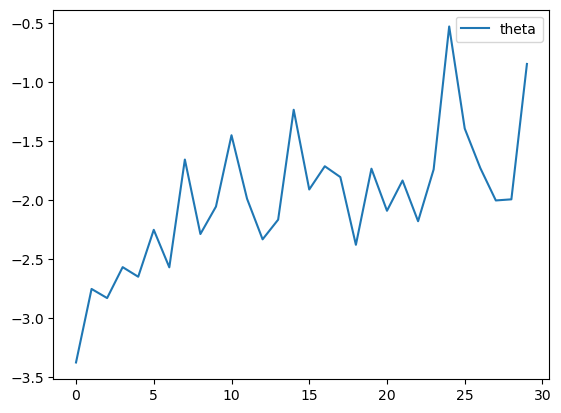

In [22]:
# t_x, t_y, r = transform_parameters[...,0], transform_parameters[...,1], transform_parameters[...,2]
# plt.plot(t_x, label='t_x')
# plt.plot(t_y, label='t_y')
# plt.plot(r, label='theta')
# plt.legend()
# plt.show(); plt.close()

r = transform_parameters[...,0]*180 # degrees
plt.plot(r, label='theta')
plt.legend()
plt.show(); plt.close()